# PLAN

0. [x] Get the data.
0. [x] Prepare the data for exploration.
0. [ ] Split the data into train and test sets.
0. [ ] Explore the data.
0. [ ] Do cross-validation with the data.
0. [ ] Code and evaluate several models.
0. [ ] Evaluate out of sample data (test set).

In [1]:
import os
import acquire
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from functools import reduce

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

import acquire
import prepare
from prepare import rename_columns
from prepare import replace_nonvals
from prepare import value_counts

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from env import path

# ACQUISITION

In [3]:
df1 = acquire.read_data('data01.csv')
df2 = acquire.read_data('data02.csv')
df3 = acquire.read_data('data03.csv')
df4 = acquire.read_data('data04.csv')
df5 = acquire.read_data('data05.csv')
df7 = acquire.read_data('data07.csv')

In [4]:
# dfs = [df1, df2, df3]

In [5]:
df1.head()

,CASEID,INVIEWN,B1AGE,AGER,AGERR,B2EDU,HIGHSCHL,B3EMPLY1,B3EMPLY2,B3EMPLY3,...,NAWYEAR,RELAC1,LENGTHC1,C1SITUAT,PARTNERS,PABUSE,SPANISH1,INMONTH,INYEAR,INDAY
0,108395,1,18,1,1,3,0,2,9999,9999,...,99,6,1,1,1,1,2,1,1998,27
1,108397,1,30,3,2,7,1,3,9999,9999,...,99,5,2,1,1,1,2,1,1998,27
2,108399,1,27,3,1,3,0,9,9999,9999,...,99,5,5,1,1,1,2,1,1998,30
3,108443,1,19,1,1,3,0,7,9999,9999,...,99,5,2,1,1,1,2,2,1998,9
4,108444,1,18,1,1,3,0,9,9999,9999,...,99,6,2,1,1,1,2,2,1998,9


In [6]:
# Specify columns to take from dataframes 1, 2, 3, 4, 5, and 7:


one_cols = ['CASEID',
            'ABUSED',
            'SCRSTATR',
            'LENGTHC1',
            'C1SITUAT',
            'PABUSE',
             ]


two_cols = ['CASEID',
            'D3RCHILT',
           ]

three_cols = ['CASEID',
              'E13PRGNT',
              'N7PREGNT',
              'TOTSUPRT'
             ]

four_cols = ['CASEID',
             'G1NUMBER', 
             'H1JEALUS', 
             'H2LIMIT',
             'H3KNOWNG',
             'J1HIT',
             'J2THROWN',
             'J3PUSH',
             'J4SLAP',
             'J5KICK',
             'J6OBJECT',
             'J7BEAT',
             'J8CHOKE',
             'J9KNIFE',
             'J10GUN',
             'J11SEX',
             'POWER',
             'HARASS',
            ]

five_cols = ['CASEID', 
             'B1AGE',
             'AGEDISP',
             'STDETAI',
            ]

seven_cols = ['CASEID',
              'SAMESEXR',
              'N11DRUGS',
              'N12ALCHL',
              'N13SUHIM',
              'N16CHILD',
              'N17ARRST',
              'N1FRQNCY',
              'N2SVRITY',
              'N3WEAPON',
              'N4CHOKE',
              'N5SEX',
              'N6CONTRL',
              'N8JEALUS',
              'N10CPBLE',
             ]

In [7]:
# drop dataframes down to desired features
df1 = df1[one_cols]
df2 = df2[two_cols]
df3 = df3[three_cols]
df4 = df4[four_cols]
df5 = df5[five_cols]
df7 = df7[seven_cols]

In [8]:
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)
print(df7.shape)

(705, 6)
(705, 2)
(705, 4)
(705, 18)
(705, 4)
(705, 15)


In [9]:
dfa = df1.merge(right=df2, on='CASEID')
dfa = dfa.merge(right=df3, on='CASEID')
dfa = dfa.merge(right=df4, on='CASEID')
dfa = dfa.merge(right=df5, on='CASEID')
dfa = dfa.merge(right=df7, on='CASEID')

In [10]:
dfa.shape

(705, 44)

## dfa: this is the dataframe with the NAW (Not Abused Woman) & AW (Abused Woman) cases.

In [11]:
# look at unaltered value counts
prepare.value_counts(dfa)

CASEID

-------------------------------------------------------------

ABUSED
1    497
2    208
Name: ABUSED, dtype: int64

-------------------------------------------------------------

SCRSTATR
1      455
2      118
3      115
999     17
Name: SCRSTATR, dtype: int64

-------------------------------------------------------------

LENGTHC1
1    159
2    153
3     83
4    105
5    147
6     58
Name: LENGTHC1, dtype: int64

-------------------------------------------------------------

C1SITUAT
1    395
2     18
3     74
4     10
9    208
Name: C1SITUAT, dtype: int64

-------------------------------------------------------------

PABUSE
1    464
2     27
3      6
9    208
Name: PABUSE, dtype: int64

-------------------------------------------------------------

D3RCHILT
0      339
1      136
2      113
3       57
4       32
5        9
6        9
7        5
12       1
555      1
666      1
999      2
Name: D3RCHILT, dtype: int64

-----------------------------------------------------------

In [12]:
#use prepare function to rename features 
prepare.rename_columns(dfa)

In [13]:
# run function to replace nonvalues and change values to conventionally boolean archetypes
prepare.replace_nonvals(dfa)

In [14]:
# check value counts to establish things worked
prepare.value_counts(dfa)

id

-------------------------------------------------------------

abuse_past_year
0    208
1    497
Name: abuse_past_year, dtype: int64

-------------------------------------------------------------

abuse_status
0    250
1    455
Name: abuse_status, dtype: int64

-------------------------------------------------------------

length_relationship
1    159
2    153
3     83
4    105
5    147
6     58
Name: length_relationship, dtype: int64

-------------------------------------------------------------

partner_abusive
0    300
1    405
Name: partner_abusive, dtype: int64

-------------------------------------------------------------

num_abusers
0    208
1    464
2     33
Name: num_abusers, dtype: int64

-------------------------------------------------------------

num_children
0      339
1      136
2      226
555      1
666      1
999      2
Name: num_children, dtype: int64

-------------------------------------------------------------

pregnant
0    631
1     74
Name: pregnant, dtype

# EXPLORATORY DATA ANALYSIS (EDA) OF DFA (GENERAL SAMPLE INCLUDING AW & NAW)

In [15]:
def missing_values_col(df):
    """
    Thids function returns the total missing values
    and the percent missing values by column.
    """
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    return pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})


def missing_values_row(df):
    """
    Write or use a previously written function to return the
    total missing values and the percent missing values by row.
    """
    null_count = df.isnull().sum(axis=1)
    null_percentage = (null_count / df.shape[1]) * 100
    return pd.DataFrame({'num_missing': null_count, 'percentage': null_percentage})


def handle_missing_threshold(df, prop_required_column = .3, prop_required_row = .9):
    """
    Removes columns and rows whose count of missing values exceeds threshold.
    """
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df


def count_values(column):
    return df[column].value_counts(dropna=False)

def summarize_data(df):
    
    df_head = df.head()
    print(f'HEAD\n{df_head}', end='\n\n')
   
    df_tail = df.tail()
    print(f'TAIL\n{df_tail}', end='\n\n')

    shape_tuple = df.shape
    print(f'SHAPE: {shape_tuple}', end='\n\n')
    
    df_describe = df.describe()
    print(f'DESCRIPTION\n{df_describe}', end='\n\n')
    
    df.info()
    print(f'INFORMATION')    

    print(f'VALUE COUNTS', end='\n\n')
    for col in df.columns:
        n = df[col].unique().shape[0]
        col_bins = min(n, 10)
        print(f'{col}:')
        if df[col].dtype in ['int64', 'float64'] and n > 10:
            print(df[col].value_counts(bins=col_bins, sort=False, dropna=False))
        else:
            print(df[col].value_counts(dropna=False))
        print('\n')


def plot_hist(df):
    """
    Plots the distribution of the dataframe's variables.
    """
    df.hist(figsize=(24, 20), bins=20)

In [16]:
missing_values_col(dfa)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
id,0,0.0,0,0.0,0,0.0
abuse_past_year,0,0.0,0,0.0,0,0.0
abuse_status,0,0.0,0,0.0,0,0.0
length_relationship,0,0.0,0,0.0,0,0.0
partner_abusive,0,0.0,0,0.0,0,0.0
num_abusers,0,0.0,0,0.0,0,0.0
num_children,0,0.0,0,0.0,0,0.0
pregnant,0,0.0,0,0.0,0,0.0
beaten_while_pregnant,0,0.0,0,0.0,0,0.0
support_score,0,0.0,0,0.0,0,0.0


In [17]:
missing_values_row(dfa)

,num_missing,percentage
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0


In [18]:
summarize_data(dfa)

HEAD
       id  abuse_past_year  abuse_status  length_relationship  \
0  108395                1             1                    1   
1  108397                1             1                    2   
2  108399                1             1                    5   
3  108443                1             1                    2   
4  108444                1             1                    2   

   partner_abusive  num_abusers  num_children  pregnant  \
0                1            1             1         0   
1                1            1             0         0   
2                1            1             2         0   
3                1            1             0         1   
4                1            1             1         0   

   beaten_while_pregnant  support_score       ...        \
0                      0              0       ...         
1                      0             11       ...         
2                      0              0       ...         
3            

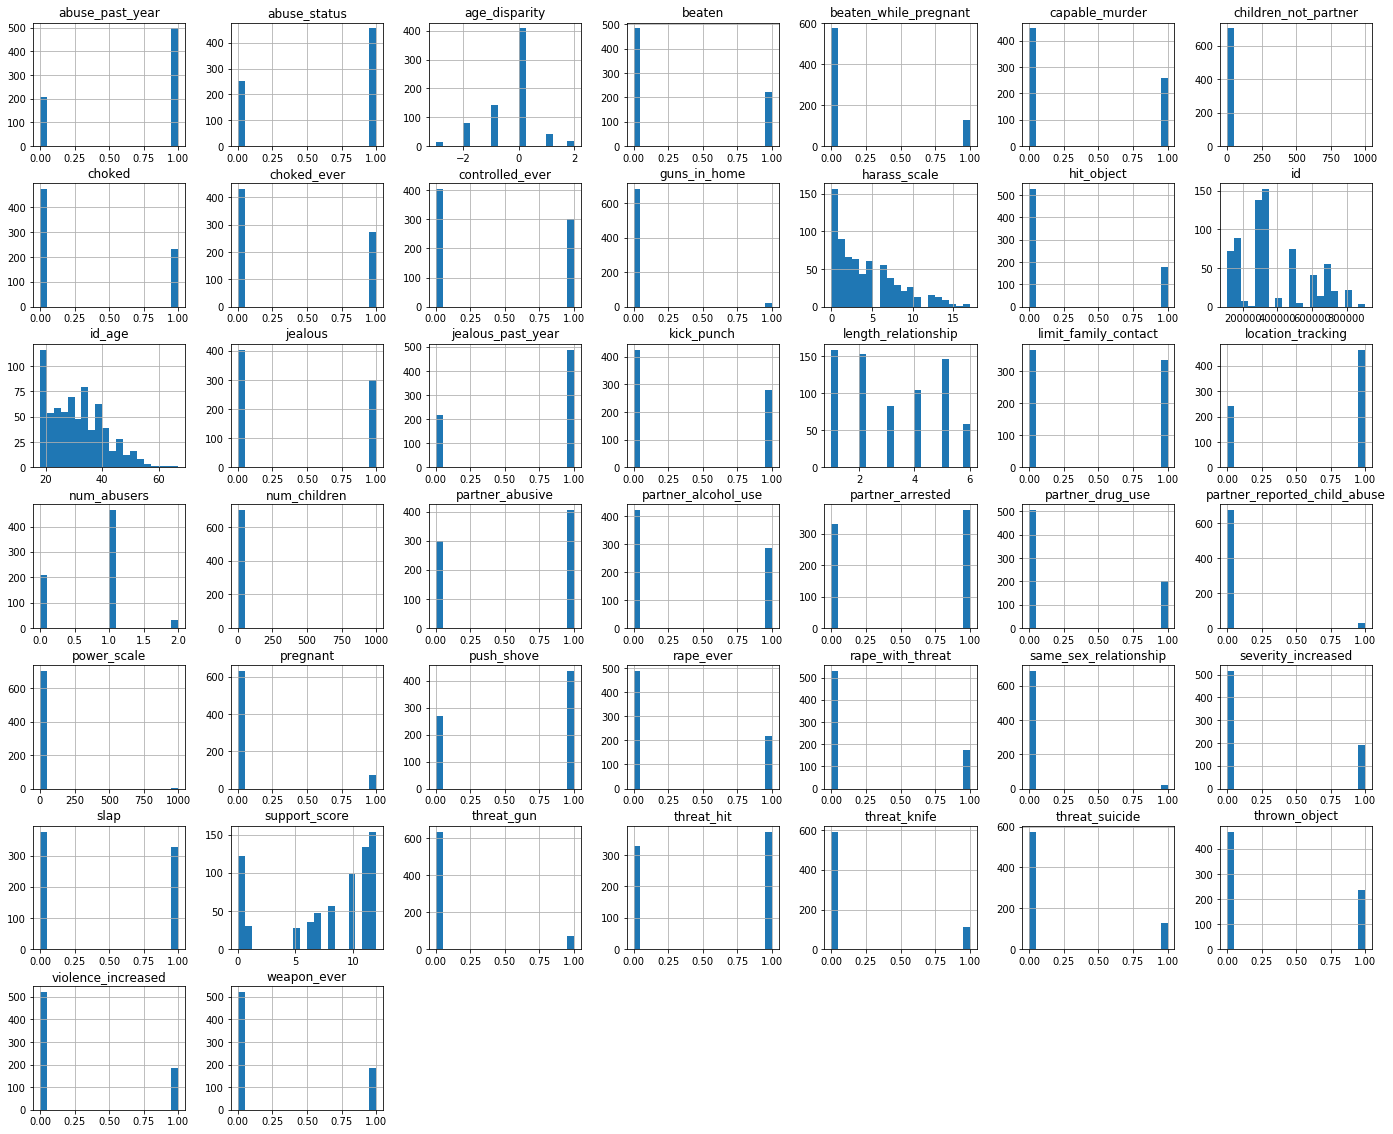

In [19]:
plot_hist(dfa)

In [20]:
dfa.head()

,id,abuse_past_year,abuse_status,length_relationship,partner_abusive,num_abusers,num_children,pregnant,beaten_while_pregnant,support_score,...,partner_reported_child_abuse,partner_arrested,violence_increased,severity_increased,weapon_ever,choked_ever,rape_ever,controlled_ever,jealous,capable_murder
0,108395,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108397,1,1,2,1,1,0,0,0,11,...,0,1,0,1,1,1,1,0,1,1
2,108399,1,1,5,1,1,2,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,108443,1,1,2,1,1,0,1,0,12,...,0,1,0,0,1,1,0,1,0,0
4,108444,1,1,2,1,1,1,0,0,11,...,0,1,1,1,0,0,0,0,0,0


In [21]:
dfa.shape

(705, 44)

In [22]:
dfa.columns

Index(['id', 'abuse_past_year', 'abuse_status', 'length_relationship',
       'partner_abusive', 'num_abusers', 'num_children', 'pregnant',
       'beaten_while_pregnant', 'support_score', 'guns_in_home',
       'jealous_past_year', 'limit_family_contact', 'location_tracking',
       'threat_hit', 'thrown_object', 'push_shove', 'slap', 'kick_punch',
       'hit_object', 'beaten', 'choked', 'threat_knife', 'threat_gun',
       'rape_with_threat', 'power_scale', 'harass_scale', 'id_age',
       'age_disparity', 'children_not_partner', 'same_sex_relationship',
       'partner_drug_use', 'partner_alcohol_use', 'threat_suicide',
       'partner_reported_child_abuse', 'partner_arrested',
       'violence_increased', 'severity_increased', 'weapon_ever',
       'choked_ever', 'rape_ever', 'controlled_ever', 'jealous',
       'capable_murder'],
      dtype='object')

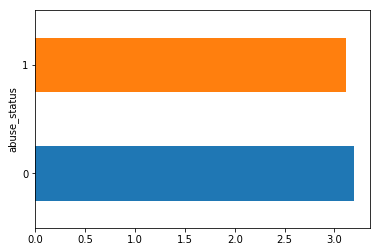

In [23]:
dfa.groupby('abuse_status')['length_relationship'].mean().plot.barh()

## The average length of the relationship is not so different for the AW and NAW groups.

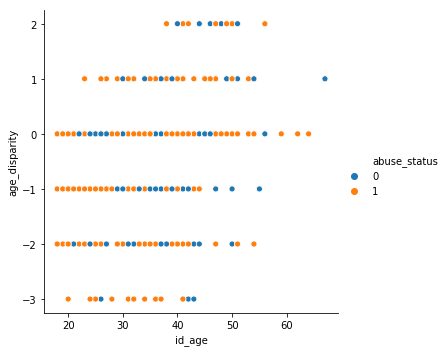

In [24]:
sns.relplot(x='id_age', y='age_disparity', data=dfa, hue='abuse_status')

In [25]:
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# We want to eliminate the violent features.

In [41]:
dfa.drop(columns={'id','abuse_past_year', 'abuse_status','partner_abusive', 'num_abusers','beaten_while_pregnant','threat_hit', 'thrown_object', 'push_shove', 'slap', 'kick_punch',
       'hit_object', 'beaten', 'choked', 'threat_knife', 'threat_gun','rape_with_threat','harass_scale','threat_suicide','violence_increased', 'severity_increased', 'weapon_ever',
       'choked_ever', 'rape_ever'}).columns

Index(['length_relationship', 'num_children', 'pregnant', 'support_score',
       'guns_in_home', 'jealous_past_year', 'limit_family_contact',
       'location_tracking', 'power_scale', 'id_age', 'age_disparity',
       'children_not_partner', 'same_sex_relationship', 'partner_drug_use',
       'partner_alcohol_use', 'partner_reported_child_abuse',
       'partner_arrested', 'controlled_ever', 'jealous', 'capable_murder'],
      dtype='object')

In [ ]:
x_columns = ['',
            ]

X = dfa[x_columns]
y = dfa[['abuse_past_year']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 0, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-

# Taking a peek at the other data that we have... 

# Dataframes 6 & 11 contain information on AW (Abused Woman) cases.

In [26]:
df6 = acquire.read_data('data06.csv')
# df8 = acquire.read_data('data08.csv') # NO USEFUL COLUMNS
df11 = acquire.read_data('data11.csv')
# df12 = acquire.read_data('data12.csv') # NO USEFUL COLUMNS

In [27]:
print(df6.head())
# print(df8.head())
print(df11.head())
# print(df12.head())

   CASEID  INVIEWN  ABUSED  SAMESEXR  RACER  M4GUN  M5FIRED  M6MSCRRG  \
0  108395        1       1      9999      1      2     9999         2   
1  108397        1       1      9999      9      2     9999         2   
2  108399        1       1      9999      1      2     9999         2   
3  108443        1       1      9999      1      2     9999         2   
4  108444        1       1      9999      1      2     9999         2   

   M7TIEDUP  M8PRSNT    ...     M40CNSL3  M40CNSL4  M44ADV1  M44ADV2  M44ADV3  \
0         2        2    ...         9999      9999        1     9999     9999   
1         2        1    ...         9999      9999        1     9999     9999   
2         1        1    ...         9999      9999        2        1     9999   
3         2        1    ...         9999      9999       26     9999     9999   
4         2        1    ...         9999      9999        1     9999     9999   

   M22NOINJ  M22NONED  M22PRIV  M22EMBAR  HELPTYPE  
0         1         0

In [28]:
# Specify columns to take from dataframes 6, 8, 11, and 12:


six_cols = ['CASEID',
            'M5FIRED',
            'M11HIGH',
            'M35SAFE',
            'M41ILLGL',
            'M42DAGRR',
            'M13TALKR',
            'M32OTHER',
            'M27HOW',
            'M30ARRES',
            'M31HOW',
            'M38ORDER',
           ]

eleven_cols = ['CASEID',
               'SEVERER',
               'TOTINCR',
               'THREATR',
               'SLAPR',
               'PUNCHR',
               'BEATR',
               'UWEAPON',
               'FORCEDR',
               'MISCARR',
               'RESTRAIN',
               'CHOKED',
               'NDRUNK',
               'RDRUNK',
               'BOTHDRUN',
               'NDRUGS',
               'RDRUGS',
               'BOTHDRUG',
              ]


In [29]:
# drop dataframes down to desired features
df6 = df6[six_cols]
df11 = df11[eleven_cols]

In [30]:
print(df6.shape)
print(df11.shape)

(497, 12)
(497, 18)


In [31]:
dfb = df6.merge(right=df11, on='CASEID')

## dfb: this is the dataframe with the AW (Abused Woman) cases 

In [32]:
# df9 & 10 are cases of AW (Abused Woman)
df9 = acquire.read_data('data09.csv')
df10 = acquire.read_data('data10.csv')

# df 13, 14 & 15 are cases of HOMICIDE
df13 = acquire.read_data('data13.csv')
df14 = acquire.read_data('data14.csv')
df15 = acquire.read_data('data15.csv')

In [33]:
df10.head()

,CASEID,INVIEWN,IDINCID,INCIDENT,FORCED,YEAR,MONTH,DAY,DATECERT,USOBJ,...,NDRUGS,BOTHDRUG,SUBSTANC,SEVEREST,TOINC,INTYEAR,INTMONTH,INTDAY,DAYSTOIN,DATECOM
0,108395,1,108395000,2,0,1997,12,15,2,2,...,0,0,1,2,1,1998,1,27,43,1
1,108397,1,108397000,1,0,1997,6,28,2,2,...,0,0,2,4,2,1998,1,27,213,1
2,108397,1,108397000,4,0,1998,1,20,2,1,...,0,0,2,4,999,1998,1,27,7,1
3,108399,1,108399000,1,0,1998,1,3,2,2,...,0,0,1,3,2,1998,1,30,27,1
4,108399,1,108399000,3,0,1998,1,27,2,2,...,0,0,1,3,999,1998,1,30,3,1


# Examine dfb in more detail. Take information from df10 and create a column that shows which cases had repeat offenses.

In [34]:
dfb.head()

,CASEID,M5FIRED,M11HIGH,M35SAFE,M41ILLGL,M42DAGRR,M13TALKR,M32OTHER,M27HOW,M30ARRES,...,FORCEDR,MISCARR,RESTRAIN,CHOKED,NDRUNK,RDRUNK,BOTHDRUN,NDRUGS,RDRUGS,BOTHDRUG
0,108395,9999,2,1,2,0,1,99,99999,3,...,0,0,0,0,0,0,0,0,0,0
1,108397,9999,2,1,2,0,1,99,99999,3,...,0,0,0,1,2,0,0,0,0,0
2,108399,9999,2,1,2,0,1,99,99999,3,...,0,0,1,1,0,0,0,0,0,0
3,108443,9999,2,1,2,0,1,13,99999,3,...,0,0,0,1,1,0,0,0,0,0
4,108444,9999,1,1,2,0,1,99,99999,3,...,0,0,0,0,3,0,0,0,0,0


# This new column, RECID, is a boolean value that tells us whether the cases were re-assault cases or not.

# So now we can see the cases where recidivism happened. There are 350 cases out of 705. There were 497 cases of domestic violence.

In [35]:
dfb[dfb.RECID == 1]

AttributeError: 'DataFrame' object has no attribute 'RECID'

In [ ]:
df13

In [ ]:
df14

In [ ]:
df15

In [ ]:
df11